This notebook aims to investigate the probability of a random customer actually buying something in the reference week, to see how high the importance is of the training interval length and the missing candidates being added.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter, PercentFormatter
import seaborn as sns

sns.set_style("whitegrid")

In [3]:
all_transactions = pd.read_parquet('../../../data/transactions_train.parquet')
articles = pd.read_parquet('../../../data/articles.parquet')
customers = pd.read_parquet('../../../data/customers.parquet')

In [4]:
# Time since last purchase of customer in weeks
current_week = all_transactions["week"].max()

last_purchase = all_transactions.groupby("customer_id")["week"].max()
last_purchase

customer_id
4245900472157            81
23962613628581           45
25398598941468           60
28847241659200          102
41046458195168           80
                       ... 
18446630855572834764    103
18446662237889060501    100
18446705133201055310    102
18446723086055369602      8
18446737527580148316    104
Name: week, Length: 1362281, dtype: int8

In [5]:
# Join with customers, fill missing values with 0
purchases = customers.merge(last_purchase, how="left", left_on="customer_id", right_index=True)
purchases = purchases.rename(columns={"week": "last_purchase"})
purchases["last_purchase"] = purchases["last_purchase"].fillna(0)
purchases = purchases[['customer_id', 'last_purchase']]
purchases["time_since_last_purchase"] = current_week - purchases["last_purchase"]
purchases

,customer_id,last_purchase,time_since_last_purchase
0,6883939031699146327,102.0,2.0
1,11246327431398957306,94.0,10.0
2,18439897732908966680,103.0,1.0
3,18352672461570950206,37.0,67.0
4,18162778555210377306,99.0,5.0
...,...,...,...
1371975,7551062398649767985,102.0,2.0
1371976,9305341941720086711,99.0,5.0
1371977,10160427316885688932,103.0,1.0
1371978,2551401172826382186,91.0,13.0


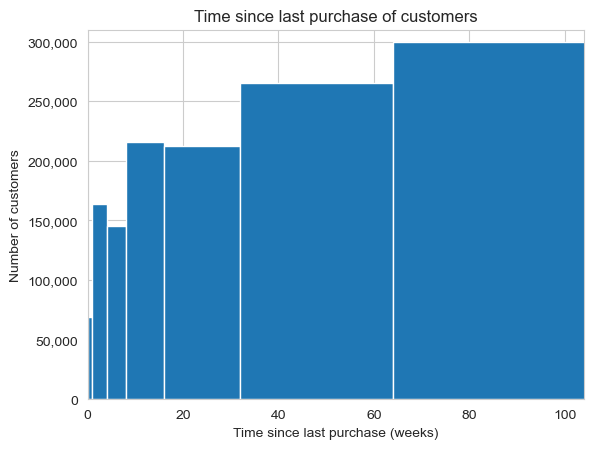

In [6]:
# Graph times since last purchases in buckets of 1, 4, 8, 16, 32, 64, 128 weeks  
plt.hist(purchases["time_since_last_purchase"], bins=[0, 1, 4, 8, 16, 32, 64, 128])

plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.xlabel("Time since last purchase (weeks)")
plt.ylabel("Number of customers")

plt.xlim(0, current_week)
plt.ylim(0, 310000)

plt.title("Time since last purchase of customers")

plt.show()

~30% of total customer base bought something in the last 20 weeks

In [7]:
# Print the number of customers in each bucket (1, 4, 8, 16, 32, 64, 128)
purchases["time_since_last_purchase"].value_counts(bins=[0, 1, 4, 8, 16, 32, 64, 128])

(64.0, 128.0]    289868
(32.0, 64.0]     264565
(8.0, 16.0]      203883
(16.0, 32.0]     203870
(1.0, 4.0]       144833
(4.0, 8.0]       136628
(-0.001, 1.0]    128333
Name: count, dtype: int64

In [8]:
# Get the amount of weeks a customer makes purchases in
weeks_with_purchases = all_transactions.groupby("customer_id")["week"].nunique()
weeks_with_purchases

customer_id
4245900472157            1
23962613628581           2
25398598941468           1
28847241659200          37
41046458195168           1
                        ..
18446630855572834764     2
18446662237889060501     3
18446705133201055310     1
18446723086055369602     2
18446737527580148316    13
Name: week, Length: 1362281, dtype: int64

In [9]:
# Join with purchases, divide by total weeks to get activity
purchases = purchases.merge(weeks_with_purchases, how="left", left_on="customer_id", right_index=True)
purchases = purchases.rename(columns={"week": "weeks_with_purchases"})
purchases["activity"] = purchases["weeks_with_purchases"] / current_week
purchases["activity"] = purchases["activity"].fillna(0)
purchases = purchases[['customer_id', 'time_since_last_purchase', 'activity']]
purchases

,customer_id,time_since_last_purchase,activity
0,6883939031699146327,2.0,0.096154
1,11246327431398957306,10.0,0.173077
2,18439897732908966680,1.0,0.057692
3,18352672461570950206,67.0,0.009615
4,18162778555210377306,5.0,0.057692
...,...,...,...
1371975,7551062398649767985,2.0,0.105769
1371976,9305341941720086711,5.0,0.173077
1371977,10160427316885688932,1.0,0.163462
1371978,2551401172826382186,13.0,0.038462


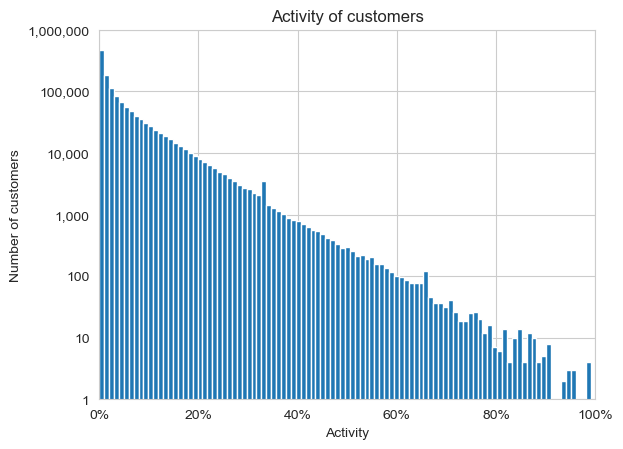

In [10]:
# Plot the activity of customers with log scale
plt.hist(purchases["activity"], bins=100, log=True)

# Print percentages on x axis, thousands on y axis
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.xlim(0, 1)
plt.ylim(1, 1000000)
plt.xlabel("Activity")
plt.ylabel("Number of customers")
plt.title("Activity of customers")

plt.show()

This graph gives the general probability of a random user making a purchase in any given week. As is clear, *most* customers only go to the store sporadically

In [11]:
# Get average purchase probability of customer purchasing an item in the next week by combining the two previous features (activity is % of a customer purchasing an item in the next week, power is the time since last purchase)


# Use a sigmoid function to get the probability of a customer purchasing an item in the next week
import numpy as np
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


# Create an adjusted activity feature that maps from 0 - 1, where time_since_last_purchase indicates higher activity
purchases["adjusted_time_since_last_purchase"] = np.exp(-0.5 * purchases["time_since_last_purchase"])

# Combine the two features
purchases["purchase_probability"] = sigmoid(np.exp(0.18 * purchases["activity"]) * purchases["adjusted_time_since_last_purchase"])

# Normalize the purchase probability
purchases["purchase_probability"] = (purchases["purchase_probability"] - purchases["purchase_probability"].min()) / (purchases["purchase_probability"].max() - purchases["purchase_probability"].min())

purchases

,customer_id,time_since_last_purchase,activity,adjusted_time_since_last_purchase,purchase_probability
0,6883939031699146327,2.0,0.096154,3.678794e-01,3.455801e-01
1,11246327431398957306,10.0,0.173077,6.737947e-03,6.492497e-03
2,18439897732908966680,1.0,0.057692,6.065307e-01,5.551566e-01
3,18352672461570950206,67.0,0.009615,2.825757e-15,2.488728e-15
4,18162778555210377306,5.0,0.057692,8.208500e-02,7.742494e-02
...,...,...,...,...,...
1371975,7551062398649767985,2.0,0.105769,3.678794e-01,3.461649e-01
1371976,9305341941720086711,5.0,0.173077,8.208500e-02,7.904789e-02
1371977,10160427316885688932,1.0,0.163462,6.065307e-01,5.651697e-01
1371978,2551401172826382186,13.0,0.038462,1.503439e-03,1.413997e-03


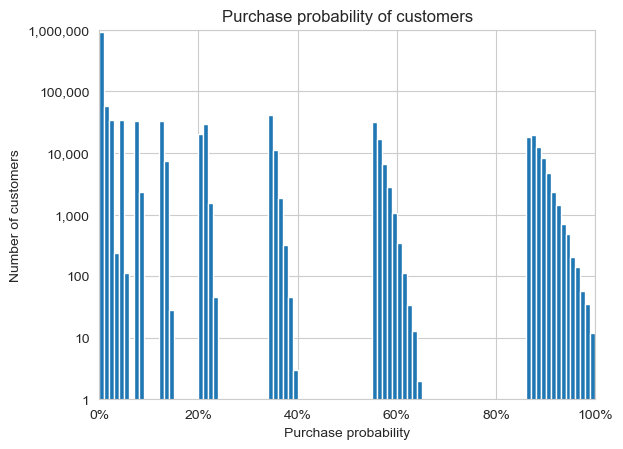

In [12]:
# Plot the purchase probability of customers with log scale
plt.hist(purchases["purchase_probability"], bins=100, log=True)

# Print percentages on x axis, thousands on y axis
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))

plt.xlim(0, 1)
plt.ylim(1, 1000000)
plt.xlabel("Purchase probability")
plt.ylabel("Number of customers")
plt.title("Purchase probability of customers")

plt.show()

# It doesn't make any sense, but it doesn't have to™

This graph was an attempt of combining the activity and time since last purchase into a single metric, so we could designate customers with a higher purchase probability as more important customers to investigate.